# CNN Model to classify a disease based on the chest x-ray

In [34]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [5]:
data_entry_file_name = "Data_Entry_2017.csv"
#bbox_list_file_name = "BBox_List_2017.csv"
data_entry_df  = pd.read_csv(data_entry_file_name)
#bbox_df = pd.read_csv(bbox_list_file_name)

In [6]:
data_entry_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [7]:
#let's rename the columns in our dataframe so that it's more compact 
data_entry_df.rename(columns={"OriginalImage[Width": "ImageWidth", "Height]": "ImageHeight", 
                              "OriginalImagePixelSpacing[x": "ImgPixelSpacingX", "y]": "ImgPixelSpacingY"})

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImageWidth,ImageHeight,ImgPixelSpacingX,ImgPixelSpacingY
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [8]:
data_entry_set = set(data_entry_df['Finding Labels'])
#data_entry_set

In [9]:
data_entry_df['Finding Labels'].value_counts()

No Finding                                                     60361
Infiltration                                                    9547
Atelectasis                                                     4215
Effusion                                                        3955
Nodule                                                          2705
                                                               ...  
Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule                  1
Consolidation|Infiltration|Nodule|Pneumonia                        1
Consolidation|Mass|Nodule|Pneumonia                                1
Consolidation|Emphysema|Infiltration|Nodule                        1
Atelectasis|Effusion|Infiltration|Pneumothorax|Cardiomegaly        1
Name: Finding Labels, Length: 836, dtype: int64

In [10]:
data_entry_df[data_entry_df['Patient Age']== 25]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
573,00000140_000.png,No Finding,0,140,25,F,PA,2048,2500,0.168000,0.168000
979,00000245_000.png,No Finding,0,245,25,M,AP,2500,2048,0.171000,0.171000
1239,00000317_002.png,No Finding,2,317,25,F,PA,2048,2500,0.168000,0.168000
1334,00000344_004.png,Nodule,4,344,25,M,PA,2992,2991,0.143000,0.143000
1816,00000468_051.png,No Finding,51,468,25,M,PA,2048,2500,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
111678,00030589_000.png,No Finding,0,30589,25,M,PA,2021,2021,0.194311,0.194311
111778,00030627_000.png,No Finding,0,30627,25,F,PA,2021,2021,0.194311,0.194311
111945,00030685_001.png,No Finding,1,30685,25,M,AP,3056,2544,0.139000,0.139000
112068,00030769_000.png,No Finding,0,30769,25,F,PA,1637,1788,0.194311,0.194311


The data looks good. So now, let's try to read some of the x-ray images

In [32]:
home_path = os.path.expanduser('~')
git_dir = os.path.join(home_path, "Documents\\WFT\\DataScience\\Git")
nih_dir = os.path.join(git_dir, "NIH-CHEST-XRAY")
data_dir = os.path.join(nih_dir, "data")
train_val_imagelist_file = os.path.join(data_dir, "train_val_list.txt")
images_001_dir = os.path.join(data_dir, "images_001\\images")
images_001_list = []

train_val_file = open(train_val_imagelist_file , 'r')
for line in train_val_file:
    line = line.rstrip("\n")
    file_loc = os.path.join(images_001_dir, line)
    images_001_list.append(file_loc)
train_val_file.close()

['C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000001_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000001_001.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000001_002.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000002_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000004_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000005_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000005_001.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images_001\\images\\00000005_002.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHES

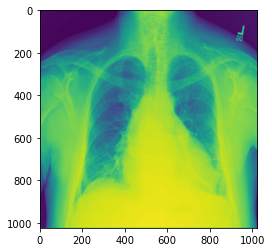

In [38]:
image_index_1 = 2

image_orig_1 = Image.open(images_001_list[image_index_1])
plt.imshow(image_orig_1)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#ax1.imshow(image_orig_1)
